In [3719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

In [3720]:
rb_df = pd.read_csv('data/Copy of Pahowdy\'s MS Database - RB1.csv')

In [3721]:
new_header = rb_df.iloc[0] 
rb_df = rb_df[1:] 
rb_df.columns = new_header

In [3722]:
rb_df.drop(['my Player ID', 'School', 'Conference', 'NFL POS', 'Years Played', 'Years >= 20 Recs', 
            'Production Score (Pos Specific)', 'Combine Score', 'Post Draft', 'PRE-DRAFT', '# of top 5  finishes', 
            '# of top  12 finishes', '# of top  24 finishes', '# of top  36 finishes', 
            '# of 1000 Rush yards seasons'],axis=1, inplace=True)

In [3723]:
# drop 2020 college players
rb_df.drop(list(range(1, 17)), inplace=True)

In [3724]:
rb_df = rb_df.reset_index(drop=True)

In [3725]:
rb_df = rb_df.set_index('Name')

In [3726]:
# function to change elements to numeric
def clean(df):
    for i in df:
        if isinstance(i, str):
            var = pd.to_numeric(df[f'{i}'], errors='coerce')
            df[f'{i}'] = var
        else:
            var = pd.to_numeric(df[i], errors='coerce')
            df[i] = var
    return df

In [3727]:
# elements to numeric
rb_df = clean(rb_df)

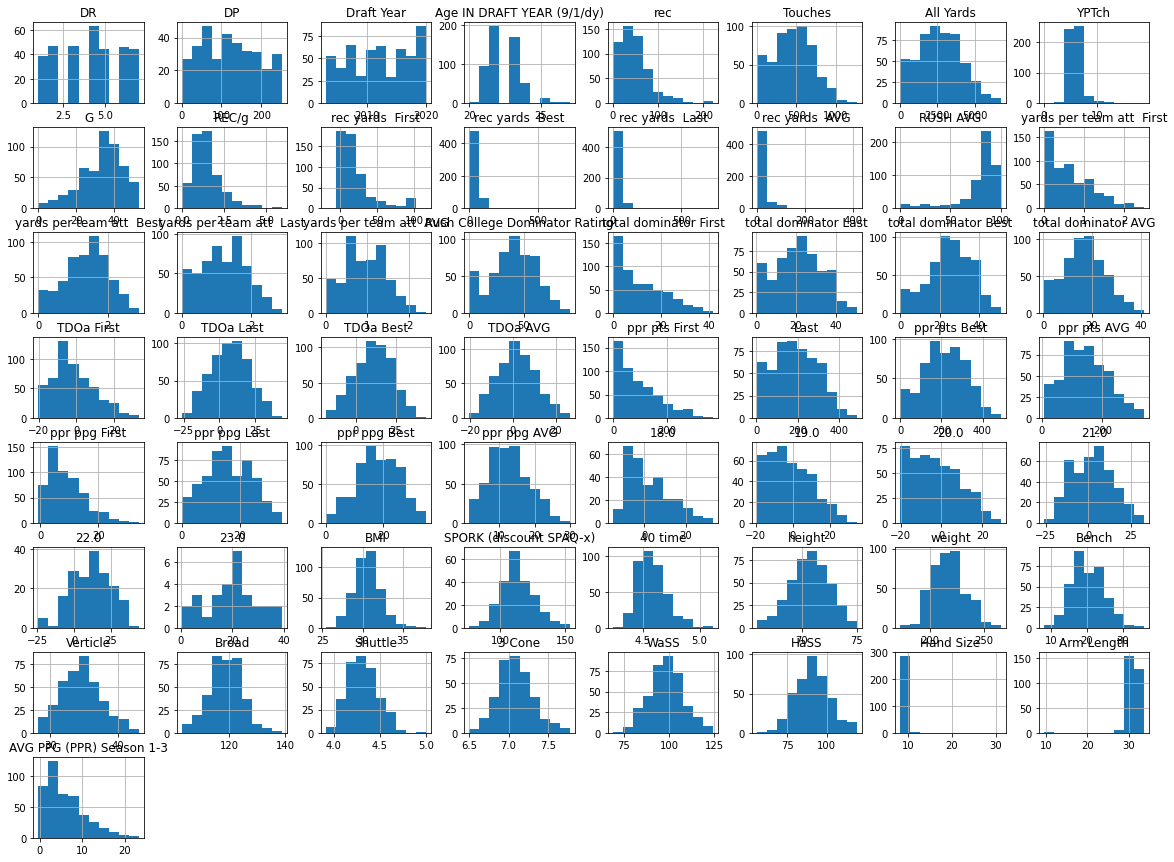

In [3728]:
rb_df.hist(figsize=(20,15))
plt.show()

In [3729]:
rookies_2020 = rb_df.iloc[0:54]

In [3730]:
rb_df = rb_df.iloc[54:]
train_set, test_set = train_test_split(rb_df, test_size=0.2, random_state=42)

In [3731]:
rb_df = train_set.copy()
df_test = test_set.copy()

In [3732]:
corr_matrix = rb_df.corr()
corr_matrix['AVG PPG (PPR) Season 1-3'].sort_values(ascending=False)

0
AVG PPG (PPR) Season 1-3         1.000000
ppr pts Best                     0.491406
ppr ppg Best                     0.478303
ppr ppg AVG                      0.476850
ppr pts AVG                      0.476552
yards per team att  Best         0.471962
yards per team att  AVG          0.468464
All Yards                        0.449229
ppr ppg Last                     0.424690
Last                             0.421116
yards per team att  Last         0.405819
total dominator AVG              0.404281
total dominator Best             0.400899
Touches                          0.380426
TDOa AVG                         0.371908
22.0                             0.368199
19.0                             0.361900
18.0                             0.357680
Rush College Dominator Rating    0.355269
yards per team att  First        0.334161
total dominator Last             0.332419
21.0                             0.331094
TDOa First                       0.320695
WaSS                            

In [3733]:
# attributes = ['AVG PPG (PPR) Season 1-3', 'yards per team att  Best', 'ppr ppg Best', 'All Yards',
#               'total dominator Best']
attributes = rb_df.columns

In [3734]:
# pd.plotting.scatter_matrix(rb_df[attributes], figsize=(12, 8))

In [3735]:
rb_labels = rb_df['AVG PPG (PPR) Season 1-3'].fillna(0)
test_labels = df_test['AVG PPG (PPR) Season 1-3'].fillna(0)
rookies_2020_labels = rookies_2020['AVG PPG (PPR) Season 1-3'].fillna(0)

In [3736]:
rb_df.drop(['AVG PPG (PPR) Season 1-3'], axis=1, inplace=True)
df_test.drop(['AVG PPG (PPR) Season 1-3'], axis=1, inplace=True)
rookies_2020.drop(['AVG PPG (PPR) Season 1-3'], axis=1, inplace=True)

In [3737]:
undrafted_dr = rb_df['DR'].max()+1
undrafted_dp = rb_df['DP'].max()+1

In [3738]:
# changed nan in draft round and draft position to 8 & 255
def draft_nan(df):
    df['DR'].fillna(undrafted_dr, inplace=True)
    df['DP'].fillna(undrafted_dp, inplace=True)
    return df

In [3739]:
# fill nan in breakout age to 0
def age_nan(df):
    df[18.0].fillna(0, inplace=True)
    df[19.0].fillna(0, inplace=True)
    df[20.0].fillna(0, inplace=True)
    df[21.0].fillna(0, inplace=True)
    df[22.0].fillna(0, inplace=True)
    df[23.0].fillna(0, inplace=True)
    return df

In [3740]:
rb_df = draft_nan(rb_df)
rb_df = age_nan(rb_df)
df_test = draft_nan(df_test)
df_test = age_nan(df_test)
rookies_2020 = draft_nan(rookies_2020)
rookies_2020 = age_nan(rookies_2020)

In [3741]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())])
rb_df_prepared = num_pipeline.fit_transform(rb_df)
df_test_prepared = num_pipeline.transform(df_test)

# Linear regression

In [3556]:
lin_reg = LinearRegression()
lin_reg.fit(rb_df_prepared, rb_labels)

LinearRegression()

In [3557]:
rb_predictions = lin_reg.predict(rb_df_prepared)
lin_mse = mse(rb_labels, rb_predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.365126090492233

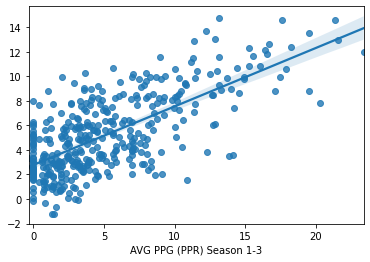

In [3558]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3559]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('SD:', scores.std())

In [3560]:
lin_scores = cross_val_score(lin_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.72946323 3.70931407 3.50039813 4.53067299 3.85635057 4.55831111
 4.7954259  4.13442449 3.69809162 4.07333342]
Mean: 4.058578552314023
SD: 0.41644147932841624


In [3561]:
r2_score(rb_labels, rb_predictions)

0.47705546355007056

In [3562]:
rb_predictions = lin_reg.predict(df_test_prepared)
lin_mse = mse(test_labels, rb_predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

4.094965612671337

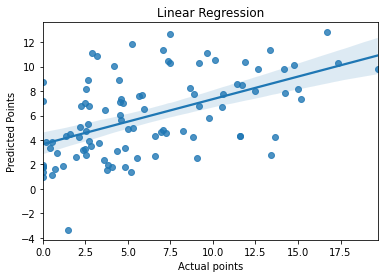

In [3563]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)
plt.xlabel('Actual points')
plt.ylabel('Predicted Points')
plt.title('Linear Regression')
plt.savefig('linear_regression.png')

In [3564]:
lin_scores = cross_val_score(lin_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 6.32432839  5.21395513  9.44868603 10.1635619   6.88461738  6.1932882
  6.13614646  8.9255993   2.11435736  8.22600664]
Mean: 6.963054678804115
SD: 2.238925971316854


In [3565]:
lin_reg_r2 = r2_score(test_labels, rb_predictions)

# Decision Tree

In [3566]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(rb_df_prepared, rb_labels)

DecisionTreeRegressor()

In [3567]:
rb_predictions = tree_reg.predict(rb_df_prepared)
tree_mse = mse(rb_labels, rb_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

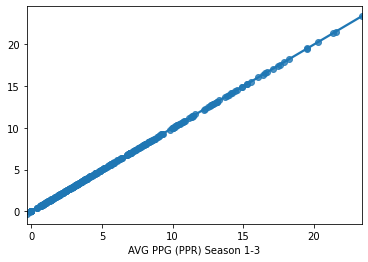

In [3568]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3569]:
tree_scores = cross_val_score(tree_reg, rb_df_prepared, rb_labels, 
                         scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [5.03458511 4.82077945 4.78935901 5.21089659 5.16657039 6.13653487
 4.74189889 4.65341254 4.89443636 4.37064767]
Mean: 4.98191208690546
SD: 0.45081212276053745


In [3570]:
r2_score(rb_labels, rb_predictions)

1.0

In [3571]:
rb_predictions = tree_reg.predict(df_test_prepared)
tree_mse = mse(test_labels, rb_predictions)  
tree_rmse = np.sqrt(tree_mse)
tree_rmse

5.359618215700026

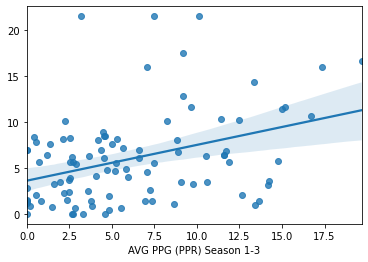

In [3572]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3573]:
tree_scores = cross_val_score(tree_reg, df_test_prepared, test_labels, 
                         scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [6.18364613 5.32178487 5.17022246 5.31166157 2.27297065 4.98839275
 3.12715321 7.40722543 2.77161455 5.56050205]
Mean: 4.811517366208423
SD: 1.5262500674131048


In [3574]:
tree_r2 = r2_score(test_labels, rb_predictions)

# Random Forest

In [3575]:
forest_reg = RandomForestRegressor()
forest_reg.fit(rb_df_prepared, rb_labels)

RandomForestRegressor()

In [3576]:
rb_predictions = forest_reg.predict(rb_df_prepared)
forest_mse = mse(rb_labels, rb_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.3502149269183152

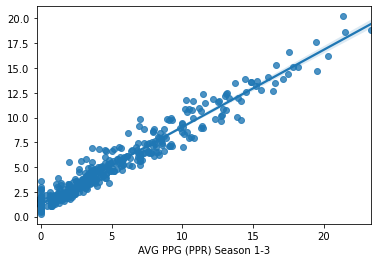

In [3577]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3578]:
forest_scores = cross_val_score(forest_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3.21044357 3.27124611 3.15562678 3.51140969 3.80638428 4.71718892
 4.08365082 3.63048697 3.44037446 3.63758632]
Mean: 3.646439792364948
SD: 0.44676937589746946


In [3579]:
r2_score(rb_labels, rb_predictions)

0.9158103398816763

In [3580]:
rb_predictions = forest_reg.predict(df_test_prepared)
forest_mse = mse(test_labels, rb_predictions)  
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3.786081773687919

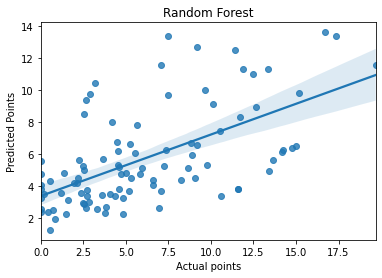

In [3581]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)
plt.xlabel('Actual points')
plt.ylabel('Predicted Points')
plt.title('Random Forest')
plt.savefig('random_forest.png')

In [3582]:
forest_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4.02713711 4.15815279 4.06490411 4.34010156 3.39980017 3.87142541
 2.84543438 5.66192607 3.25694622 4.37770338]
Mean: 4.00035312065326
SD: 0.7288490342836689


In [3583]:
forest_r2 = r2_score(test_labels, rb_predictions)

# Random Forest Grid Search

In [3584]:
param_grid = [{'n_estimators': [300, 350, 400], 'max_features': [30, 35, 40, 45, 50], 'max_depth': [3, 5, 10, None]}]

forest_reg_grid = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg_grid, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1, verbose=1)
grid_search.fit(rb_df_prepared, rb_labels)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [3, 5, 10, None],
                          'max_features': [30, 35, 40, 45, 50],
                          'n_estimators': [300, 350, 400]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [3585]:
grid_search.best_params_

{'max_depth': None, 'max_features': 40, 'n_estimators': 350}

In [3586]:
grid_search.best_estimator_
best = grid_search.best_estimator_
best

RandomForestRegressor(max_features=40, n_estimators=350)

In [3587]:
forest_reg_grid = best
forest_reg_grid.fit(rb_df_prepared, rb_labels)

RandomForestRegressor(max_features=40, n_estimators=350)

In [3588]:
rb_predictions = forest_reg_grid.predict(rb_df_prepared)
forest_grid_mse = mse(rb_labels, rb_predictions)
forest_grid_rmse = np.sqrt(forest_grid_mse)
forest_rmse

3.786081773687919

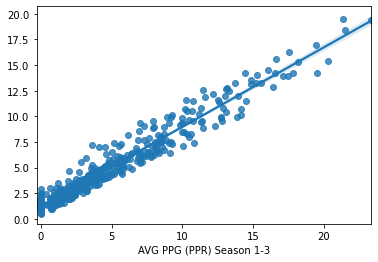

In [3589]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3590]:
forest_grid_scores = cross_val_score(forest_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
forest_grid_rmse_scores = np.sqrt(-forest_grid_scores)
display_scores(forest_grid_rmse_scores)

Scores: [3.18767718 3.18300947 3.19287601 3.60265996 3.78177203 4.62120705
 4.32851828 3.60678265 3.34793379 3.69376962]
Mean: 3.6546206050494296
SD: 0.4646325475735549


In [3591]:
r2_score(rb_labels, rb_predictions)

0.9143549892720266

In [3743]:
rb_predictions = forest_reg_grid.predict(df_test_prepared)
forest_grid_mse = mse(test_labels, rb_predictions)  
forest_grid_rmse = np.sqrt(forest_grid_mse)
forest_rmse

3.786081773687919

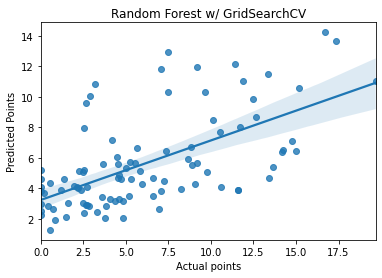

In [3744]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)
plt.xlabel('Actual points')
plt.ylabel('Predicted Points')
plt.title('Random Forest w/ GridSearchCV')
plt.savefig('rf_gridsearch.png')

In [3745]:
forest_grid_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
forest_grid_rmse_scores = np.sqrt(-forest_grid_scores)
display_scores(forest_grid_rmse_scores)

Scores: [3.96374726 4.33543791 3.93025593 4.51923638 3.14746298 3.62388621
 2.61189995 5.75416966 3.11855543 4.66266406]
Mean: 3.966731577532836
SD: 0.8640322727457639


In [3595]:
forest_grid_r2 = r2_score(test_labels, rb_predictions)

In [3596]:
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# SVR Linear

In [3597]:
lin_svr = SVR(kernel='linear')
lin_svr.fit(rb_df_prepared, rb_labels)

SVR(kernel='linear')

In [3598]:
rb_predictions = lin_svr.predict(rb_df_prepared)

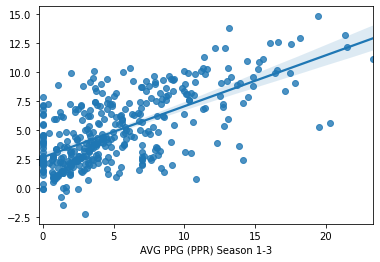

In [3599]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3600]:
svr_scores = cross_val_score(lin_svr, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [3.58813771 3.60350329 3.30181515 4.26638983 4.05022065 4.73395043
 4.71718563 4.30655019 3.72186451 3.73502147]
Mean: 4.002463886224375
SD: 0.46715218878046605


In [3601]:
r2_score(rb_labels, rb_predictions)

0.4292079261291104

In [3602]:
rb_predictions = lin_svr.predict(df_test_prepared)

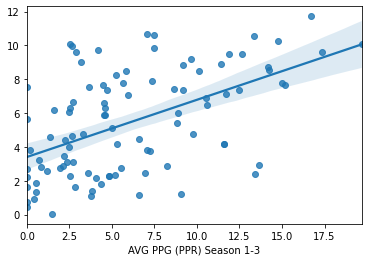

In [3603]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3604]:
svr_scores = cross_val_score(lin_svr, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [5.19640483 5.02461715 4.82653222 5.02355601 4.24514719 3.85314178
 5.35890408 5.51201387 2.11816157 6.08935987]
Mean: 4.7247838571303715
SD: 1.0526225390636705


In [3605]:
svr_linear_r2 = r2_score(test_labels, rb_predictions)

# Gradient Descent

In [3606]:
sgd_reg = SGDRegressor()
sgd_reg.fit(rb_df_prepared, rb_labels)

SGDRegressor()

In [3607]:
rb_predictions = sgd_reg.predict(rb_df_prepared)

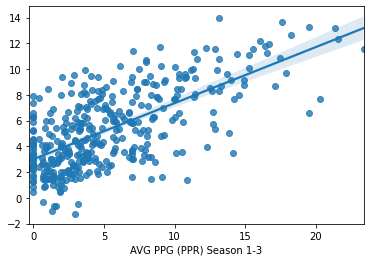

In [3608]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3609]:
sgd_scores = cross_val_score(sgd_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)
display_scores(sgd_rmse_scores)

Scores: [3.41548549 3.62447397 3.07970053 4.15110247 3.78354718 4.7191537
 4.66456724 4.22544874 3.23694405 3.56851314]
Mean: 3.846893649054208
SD: 0.542493359612423


In [3610]:
r2_score(rb_labels, rb_predictions)

0.44252391372249

In [3611]:
rb_predictions = sgd_reg.predict(df_test_prepared)

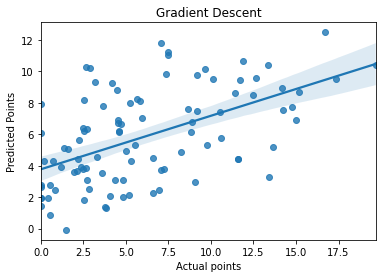

In [3612]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)
plt.xlabel('Actual points')
plt.ylabel('Predicted Points')
plt.title('Gradient Descent')
plt.savefig('grad_descent.png')

In [3613]:
sgd_scores = cross_val_score(sgd_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)
display_scores(sgd_rmse_scores)

Scores: [4.30429944 5.02399488 5.14761244 4.6567866  4.36581176 3.93812188
 4.28454154 6.42546365 2.42753058 6.50555266]
Mean: 4.707971543768408
SD: 1.128239723274451


In [3614]:
grad_des_r2 = r2_score(test_labels, rb_predictions)

# Lasso

In [3615]:
lasso_reg = Lasso()
lasso_reg.fit(rb_df_prepared, rb_labels)

Lasso()

In [3616]:
rb_predictions = lasso_reg.predict(rb_df_prepared)

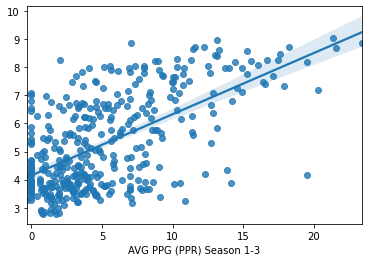

In [3617]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3618]:
lasso_scores = cross_val_score(lasso_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

Scores: [3.71313238 4.14191866 2.63132076 3.47360185 3.55254608 4.93550723
 4.72026315 3.79563619 3.70659762 4.07730446]
Mean: 3.8747828388113854
SD: 0.6183859428877586


In [3619]:
r2_score(rb_labels, rb_predictions)

0.3067575707798683

In [3620]:
rb_predictions = lasso_reg.predict(df_test_prepared)

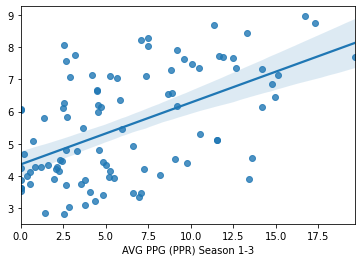

In [3621]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3622]:
lasso_scores = cross_val_score(lasso_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

Scores: [4.45450584 4.80624563 3.75822021 4.35105607 4.1235659  4.35915701
 3.79545019 4.42798138 3.33307139 5.61318783]
Mean: 4.302244144075609
SD: 0.5950823377545863


In [3623]:
lasso_r2 = r2_score(test_labels, rb_predictions)

# Elastic net

In [3624]:
elastic_net = ElasticNet()
elastic_net.fit(rb_df_prepared, rb_labels)

ElasticNet()

In [3625]:
rb_predictions = elastic_net.predict(rb_df_prepared)

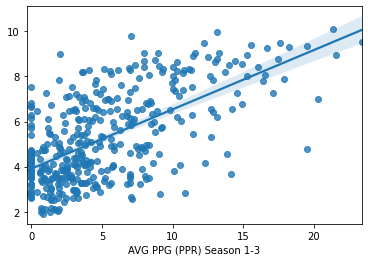

In [3626]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3627]:
elastic_scores = cross_val_score(elastic_net, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
elastic_rmse_scores = np.sqrt(-elastic_scores)
display_scores(elastic_rmse_scores)

Scores: [3.5292692  3.95960645 2.67575125 3.51168446 3.54280931 4.79717489
 4.59074781 3.77116067 3.61375133 3.86983299]
Mean: 3.7861788362159836
SD: 0.5630367715381387


In [3628]:
r2_score(rb_labels, rb_predictions)

0.343369055931779

In [3629]:
rb_predictions = elastic_net.predict(df_test_prepared)

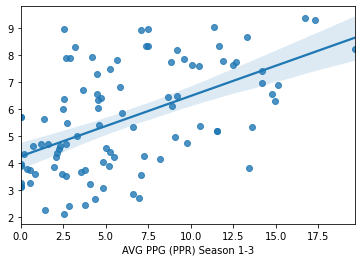

In [3630]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3631]:
elastic_scores = cross_val_score(elastic_net, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
elastic_rmse_scores = np.sqrt(-elastic_scores)
display_scores(elastic_rmse_scores)

Scores: [4.44250073 4.78554198 3.84689885 4.33841728 3.75359791 4.16463295
 3.65897931 4.7126345  3.01416544 5.31969581]
Mean: 4.2037064751892785
SD: 0.6293896955802823


In [3632]:
elastic_r2 = r2_score(test_labels, rb_predictions)

# SVR rbf

In [3633]:
rbf_svr = SVR(kernel='rbf')
rbf_svr.fit(rb_df_prepared, rb_labels)

SVR()

In [3634]:
rb_predictions = rbf_svr.predict(rb_df_prepared)

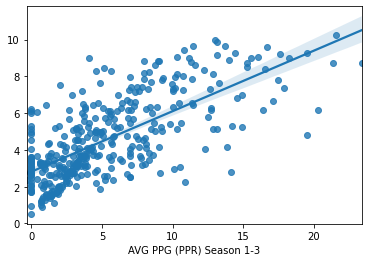

In [3635]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3636]:
rbf_scores = cross_val_score(rbf_svr, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
rbf_rmse_scores = np.sqrt(-rbf_scores)
display_scores(rbf_rmse_scores)

Scores: [3.62578228 4.08994304 2.89149634 3.52737866 3.65331843 4.9207611
 4.84280452 3.81276948 3.97840202 4.02295045]
Mean: 3.9365606331650156
SD: 0.5722229838049965


In [3637]:
r2_score(rb_labels, rb_predictions)

0.4114303871515197

In [3638]:
rb_predictions = rbf_svr.predict(df_test_prepared)

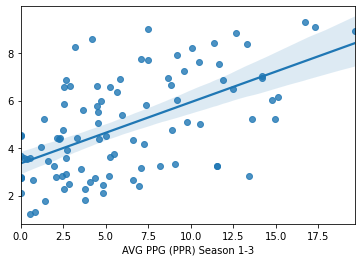

In [3639]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3640]:
rbf_scores = cross_val_score(rbf_svr, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
rbf_rmse_scores = np.sqrt(-rbf_scores)
display_scores(rbf_rmse_scores)

Scores: [4.98910641 4.95562836 3.98424266 3.8304175  4.03500547 4.85631114
 3.12697904 4.39951222 3.4671825  5.71633384]
Mean: 4.33607191485021
SD: 0.7534644239449416


In [3641]:
svr_rbf_r2 = r2_score(test_labels, rb_predictions)

# Gradient Boosting

In [3642]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(rb_df_prepared, rb_labels)

GradientBoostingRegressor()

In [3643]:
rb_predictions = grad_boost.predict(rb_df_prepared)

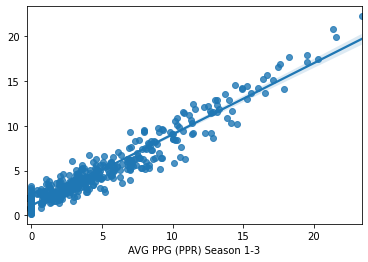

In [3644]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3645]:
grad_boost_scores = cross_val_score(grad_boost, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
grad_boost_rmse_scores = np.sqrt(-grad_boost_scores)
display_scores(grad_boost_rmse_scores)

Scores: [3.00366853 3.3056916  3.24928375 3.72948754 3.97782534 4.74350756
 4.35394111 3.77296038 3.56328329 3.82061765]
Mean: 3.7520266759116794
SD: 0.4949344140123311


In [3646]:
r2_score(rb_labels, rb_predictions)

0.9039606141835225

In [3647]:
rb_predictions = grad_boost.predict(df_test_prepared)

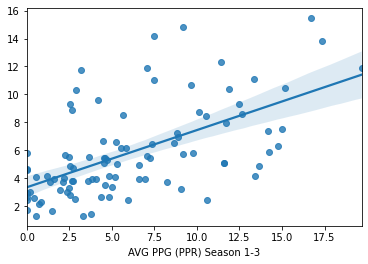

In [3648]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3649]:
grad_boost_scores = cross_val_score(grad_boost, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
grad_boost_rmse_scores = np.sqrt(-grad_boost_scores)
display_scores(grad_boost_rmse_scores)

Scores: [4.21609557 4.88721314 4.42432397 4.94164358 2.93230714 4.45180879
 2.75966929 6.79513712 3.53548821 4.97603488]
Mean: 4.391972167756719
SD: 1.1057980120622606


In [3650]:
grad_boost_r2 = r2_score(test_labels, rb_predictions)

In [3651]:
errors = [mse(test_labels, rb_predictions)
          for rb_predictions in grad_boost.staged_predict(df_test_prepared)]
bst_n_estimators = np.argmin(errors) + 1

In [3652]:
gbrt_best = GradientBoostingRegressor(n_estimators=bst_n_estimators)
gbrt_best.fit(rb_df_prepared, rb_labels)

GradientBoostingRegressor(n_estimators=58)

In [3653]:
rb_predictions = gbrt_best.predict(rb_df_prepared)

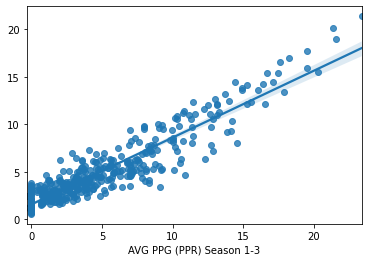

In [3654]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3655]:
r2_score(rb_labels, rb_predictions)

0.8255350551601415

In [3656]:
rb_predictions = gbrt_best.predict(df_test_prepared)

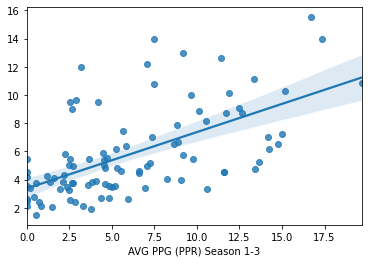

In [3657]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3658]:
grad_boost_tuned_scores = cross_val_score(gbrt_best, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
grad_boost_tuned_rmse_scores = np.sqrt(-grad_boost_tuned_scores)
display_scores(grad_boost_tuned_rmse_scores)

Scores: [4.2637919  4.7803387  4.35347479 4.81819091 3.04987013 4.29318995
 2.70858462 6.6534122  3.40900216 4.9787693 ]
Mean: 4.330862465620236
SD: 1.0668889653758817


In [3659]:
grad_boost_tuned_r2 = r2_score(test_labels, rb_predictions)

In [3660]:
print(f'Tuned Gradient Boost rmse: \t{grad_boost_tuned_rmse_scores.mean()}\n',
     f'Gradient Boost rmse: \t\t{grad_boost_rmse_scores.mean()}\n',
     f'SVR RBF rmse: \t\t\t{rbf_rmse_scores.mean()}\n',
     f'Elastic rmse: \t\t\t{elastic_rmse_scores.mean()}\n',
     f'Lasso rmse: \t\t\t{lasso_rmse_scores.mean()}\n',
     f'Gradient Descent rmse: \t{sgd_rmse_scores.mean()}\n',
     f'SVR Linear rmse: \t\t{svr_rmse_scores.mean()}\n', 
     f'RF GridSearch rmse: \t\t{forest_grid_rmse_scores.mean()}\n',
     f'Random Forest rmse: \t\t{forest_rmse_scores.mean()}\n',
     f'Decision Tree rmse: \t\t{tree_rmse_scores.mean()}\n',
     f'Linear Reggression rmse: \t{lin_rmse_scores.mean()}\n')

Tuned Gradient Boost rmse: 	4.330862465620236
 Gradient Boost rmse: 		4.391972167756719
 SVR RBF rmse: 			4.33607191485021
 Elastic rmse: 			4.2037064751892785
 Lasso rmse: 			4.302244144075609
 Gradient Descent rmse: 	4.707971543768408
 SVR Linear rmse: 		4.7247838571303715
 RF GridSearch rmse: 		3.932763461523222
 Random Forest rmse: 		4.00035312065326
 Decision Tree rmse: 		4.811517366208423
 Linear Reggression rmse: 	6.963054678804115



In [3661]:
estimators = [('gradient descent', sgd_reg),
             ('lasso', lasso_reg),
             ('SVR linear', lin_svr),]

In [3662]:
stackreg = StackingRegressor(estimators=estimators, final_estimator=forest_reg)

In [3663]:
stackreg.fit(rb_df_prepared, rb_labels)

StackingRegressor(estimators=[('gradient descent', SGDRegressor()),
                              ('lasso', Lasso()),
                              ('SVR linear', SVR(kernel='linear'))],
                  final_estimator=RandomForestRegressor())

In [3664]:
rb_predictions = stackreg.predict(rb_df_prepared)

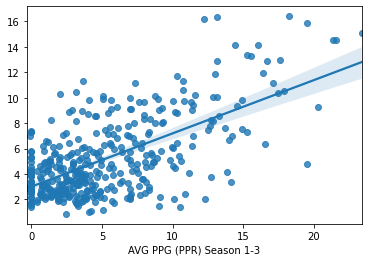

In [3665]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3666]:
r2_score(rb_labels, rb_predictions)

0.3982798992075586

In [3667]:
rb_predictions = stackreg.predict(df_test_prepared)

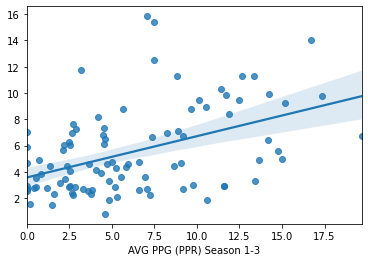

In [3668]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3669]:
stacked_scores = cross_val_score(stackreg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
stacked_rmse_scores = np.sqrt(-stacked_scores)
display_scores(stacked_rmse_scores)

Scores: [4.84637152 5.37193644 3.48237129 5.0971133  3.75505272 5.2168671
 4.41165992 4.2046515  2.47687331 6.13710411]
Mean: 4.500000119756887
SD: 1.0104152594152065


In [3670]:
r2_score(test_labels, rb_predictions)

0.14098905473681222

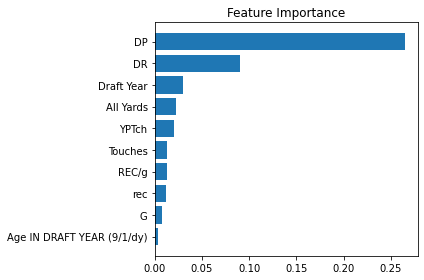

In [3759]:
feature_importance = forest_reg_grid.feature_importances_
sorted_idx = np.argsort(feature_importance[:10])
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure()
# plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(rb_df.columns)[sorted_idx])
plt.title('Feature Importance')

plt.tight_layout()
plt.savefig('feature_importance.png')

In [3672]:
sorted(zip(feature_importance, attributes), reverse=True)

[(0.35873355980434446, 'DP'),
 (0.0374173158649997, 'Draft Year'),
 (0.022150207017860128, 'Arm Length'),
 (0.02104365766096455, 'ppr pts AVG'),
 (0.019532473026303433, 'YPTch'),
 (0.01919509569192971, 'REC/g'),
 (0.018488063711558426, 'All Yards'),
 (0.01734734435526942, 'ppr pts Best'),
 (0.017065958092587673, 'Shuttle'),
 (0.016960502784773204, 'rec yards  Last'),
 (0.015881624394390028, 'DR'),
 (0.015682966983096368, 'Bench'),
 (0.015665360025783278, 'ppr ppg AVG'),
 (0.015490799043102337, 18.0),
 (0.01513700519548581, 'WaSS'),
 (0.014792156271167907, 'Hand Size'),
 (0.01471291235034797, 19.0),
 (0.013660066804730316, 'TDOa First'),
 (0.013605539197465613, 'SPORK (discount SPAQ-x)'),
 (0.01339389311950042, 'weight'),
 (0.013080334968257216, 'Last'),
 (0.012806148593576068, 'Touches'),
 (0.012591158113113968, 'total dominator Best'),
 (0.01257649074386178, 'Verticle'),
 (0.011720689526268502, 'Rush College Dominator Rating'),
 (0.011471080935625648, 20.0),
 (0.011401426747937371, 'r

# Linear Reg w/ feature importances

In [3673]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [3674]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.2651387812534223, 'DP'),
 (0.09033721550364893, 'DR'),
 (0.029891945293757802, 'Draft Year'),
 (0.023547674199900143, 'ppr ppg AVG'),
 (0.02285465999199647, 'All Yards'),
 (0.021624761928821994, 'Arm Length'),
 (0.02114637632369688, 'ppr pts Best'),
 (0.020445512488993227, 'ppr pts AVG'),
 (0.02039200240845176, 'YPTch'),
 (0.015645302431707368, 'WaSS'),
 (0.015638861729666463, 'TDOa First'),
 (0.01538082187648496, 18.0),
 (0.015343776465023927, 'Shuttle'),
 (0.014425005742479572, 'rec yards  Last'),
 (0.014422788575257627, 'total dominator Best'),
 (0.014037852356578277, 19.0),
 (0.013856655419923434, 'Rush College Dominator Rating'),
 (0.013492808725764287, 'Touches'),
 (0.013385994425595406, 'Bench'),
 (0.013337535153337087, 'REC/g'),
 (0.01305263865109137, 'Hand Size'),
 (0.013010728816064738, 'ppr ppg Best'),
 (0.012574208217754651, 20.0),
 (0.012211928272510298, 'rec'),
 (0.011907030999727288, 'rec yards  Best'),
 (0.011680297073708051, 'Last'),
 (0.01166988576481532, '40 time

In [3675]:
col_list = ['DP', 'DR', 'ppr ppg AVG', 'total dominator Best', 'WaSS', 'ppr ppg Best', 'total dominator Best', 'WaSS',
           'ppr pts AVG', 'total dominator AVG', 'All Yards', 'Arm Length', 'YPTch', 18.0, 'Shuttle', 'ppr ppg Last',
           'REC/g', 'TDOa First', 'Touches', 'Bench', 19.0, 'SPORK (discount SPAQ-x)', 'Rush College Dominator Rating']

df = rb_df[col_list]
df_test = df_test[col_list]
# rookies_2020 = rookies_2020[col_list]

In [3676]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())])
rb_df_prepared = num_pipeline.fit_transform(df)
df_test_prepared = num_pipeline.transform(df_test)

In [3677]:
lin_reg = LinearRegression()
lin_reg.fit(rb_df_prepared, rb_labels)

LinearRegression()

In [3678]:
rb_predictions = lin_reg.predict(rb_df_prepared)
lin_mse = mse(rb_labels, rb_predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.5365604262724966

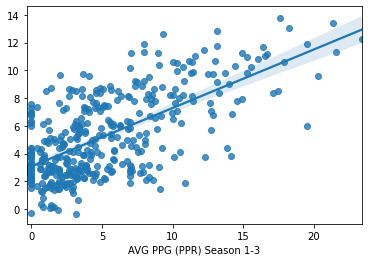

In [3679]:
df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=rb_labels,
y=rb_predictions,
scatter=True)

In [3680]:
lin_scores = cross_val_score(lin_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [3.34353587 3.32607518 3.30288173 3.92124547 3.45886695 4.71486098
 4.36057085 3.86580959 3.4578082  3.65698556]
Mean: 3.7408640379877673
SD: 0.4548936095996127


In [3681]:
r2_score(rb_labels, rb_predictions)

0.4224160556145343

In [3682]:
rb_predictions = lin_reg.predict(df_test_prepared)
lin_mse = mse(test_labels, rb_predictions)  
lin_rmse = np.sqrt(lin_mse)
lin_rmse

3.871718042362044

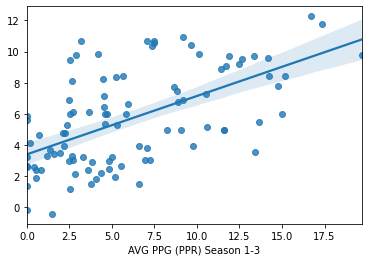

In [3683]:
df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
df = df.sort_values(by='Predicted', ascending=False)
fig, ax = plt.subplots()
plot = sns.regplot(
x=test_labels,
y=rb_predictions,
scatter=True)

In [3684]:
lin_scores = cross_val_score(lin_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [4.30728281 4.51061916 4.92981813 5.34420303 2.99133627 4.6919984
 3.84800675 5.38374118 3.63272867 5.69829483]
Mean: 4.533802922557824
SD: 0.8142691224273957


In [3685]:
r2_score(test_labels, rb_predictions)

0.3243388826564916

In [3686]:
# param_grid = [{'n_estimators': [50, 100, 500], 'max_features': [2, 4, 6, 8, 10], 'max_depth': [3, 5, 10, None]}]

# forest_reg = RandomForestRegressor()
# grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True, n_jobs=-1, verbose=1)
# grid_search.fit(rb_df_prepared, rb_labels)

In [3687]:
# grid_search.best_params_

In [3688]:
# forest_reg = RandomForestRegressor(max_depth=3, n_estimators=100)
# forest_reg.fit(rb_df_prepared, rb_labels)

In [3689]:
# rb_predictions = forest_reg.predict(rb_df_prepared)
# forest_mse = mse(rb_labels, rb_predictions)
# forest_rmse = np.sqrt(forest_mse)
# forest_rmse

In [3690]:
# df = pd.DataFrame({'Actual': rb_labels, 'Predicted': rb_predictions})
# df = df.sort_values(by='Predicted', ascending=False)
# fig, ax = plt.subplots()
# plot = sns.regplot(
# x=rb_labels,
# y=rb_predictions,
# scatter=True)

In [3691]:
# forest_scores = cross_val_score(forest_reg, rb_df_prepared, rb_labels, scoring="neg_mean_squared_error", cv=10)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

In [3692]:
# r2_score(rb_labels, rb_predictions)

In [3693]:
# rb_predictions = forest_reg.predict(df_test_prepared)
# forest_mse = mse(test_labels, rb_predictions)  
# forest_rmse = np.sqrt(forest_mse)
# forest_rmse

In [3694]:
# df = pd.DataFrame({'Actual': test_labels, 'Predicted': rb_predictions})
# df = df.sort_values(by='Predicted', ascending=False)
# fig, ax = plt.subplots()
# plot = sns.regplot(
# x=test_labels,
# y=rb_predictions,
# scatter=True)

In [3695]:
# forest_scores = cross_val_score(forest_reg, df_test_prepared, test_labels, scoring="neg_mean_squared_error", cv=10)
# forest_rmse_scores = np.sqrt(-forest_scores)
# display_scores(forest_rmse_scores)

In [3696]:
# r2_score(test_labels, rb_predictions)

In [3697]:
spork_mean = rb_df['SPORK (discount SPAQ-x)'].mean()
rookies_2020['SPORK (discount SPAQ-x)'].fillna(spork_mean, inplace=True)

In [3698]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())])
rb_df_prepared = num_pipeline.fit_transform(rookies_2020)

In [3699]:
rb_predictions = forest_reg.predict(rb_df_prepared)

In [3700]:
df = pd.DataFrame({'Actual': rookies_2020_labels, 'Predicted': rb_predictions.round(decimals=1)})
df = df.sort_values(by='Predicted', ascending=False)

In [3701]:
df['Rank'] = range(1, 55)

In [3702]:
df.reset_index(inplace=True)

In [3703]:
points = df['Predicted'].values

<BarContainer object of 10 artists>

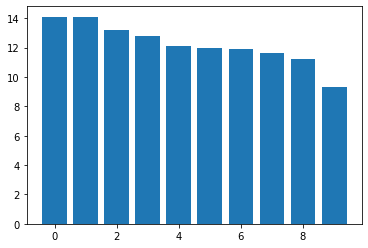

In [3704]:
plt.bar(range(10), points[:10])

In [3705]:
df.head()

,Name,Actual,Predicted,Rank
0,Jonathan Taylor,0.0,14.1,1
1,JK Dobbins,0.0,14.1,2
2,Cam Akers,0.0,13.2,3
3,Ke'Shawn Vaughn,0.0,12.8,4
4,D'Andre Swift,0.0,12.1,5


In [3706]:
import nflfastpy as nfl

In [3707]:
roster = nfl.load_2020_roster_data()

In [3708]:
roster['headshot_url'] = roster['headshot_url'].apply(lambda x: f'<img src="{x}" width="100px">')
roster['Name'] = roster['full_name']

In [3709]:
roster = roster.replace('J.K. Dobbins', 'JK Dobbins')
roster = roster.replace('A.J. Dillon', 'AJ Dillon')

In [3710]:
df_pic = roster.merge(df)

In [3711]:
df_pic = df_pic.sort_values(by='Rank')

In [3712]:
cols = ['headshot_url', 'Name', 'Predicted', 'Rank']

In [3713]:
df_pic = df_pic[cols]

In [3714]:
df_pic.rename({'headshot_url': ' '}, axis=1, inplace=True)

In [3715]:
df_pic = df_pic.sort_values(by='Rank').head(10)

In [3716]:
df_pic = df_pic.style.hide_index().format('{0:}')

In [3717]:
df_pic

,Name,Predicted,Rank
,Jonathan Taylor,14.1,1
,JK Dobbins,14.1,2
,Cam Akers,13.2,3
,Ke'Shawn Vaughn,12.8,4
,D'Andre Swift,12.1,5
,Zack Moss,12.0,6
,AJ Dillon,11.9,7
,Clyde Edwards-Helaire,11.6,8
,Antonio Gibson,11.2,9
,Darrynton Evans,9.3,10
